## 0. Load Libraries & Data

In [48]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors # 위도, 경도 기반의 거리 계산을 위해..
import gc # 메모리 확보 필수

In [49]:
# seed 설정
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [50]:
# 소수점 이하 3자리 반올림, 과학적 표기법 해제
pd.set_option('display.float_format', '{:.3f}'.format)
np.set_printoptions(suppress=True, precision=3)

## 1. 데이터 불러오기

In [51]:
# 파일 경로 설정
file_path = '../data/'

# 파일 불러오기
train_data = pd.read_csv(file_path + 'train.csv').assign(_type = 'train')
test_data = pd.read_csv(file_path + 'test.csv').assign(_type = 'test')
sample_submission = pd.read_csv(file_path + 'sample_submission.csv')
df = pd.concat([train_data, test_data], axis=0)

subwayInfo = pd.read_csv(file_path + 'subwayInfo.csv')
interestRate = pd.read_csv(file_path + 'interestRate.csv')
schoolInfo = pd.read_csv(file_path + 'schoolinfo.csv')
parkInfo = pd.read_csv(file_path + 'parkInfo.csv')

### 1. interest rate와 target의 관계

#### (1) interest rate 그려보기

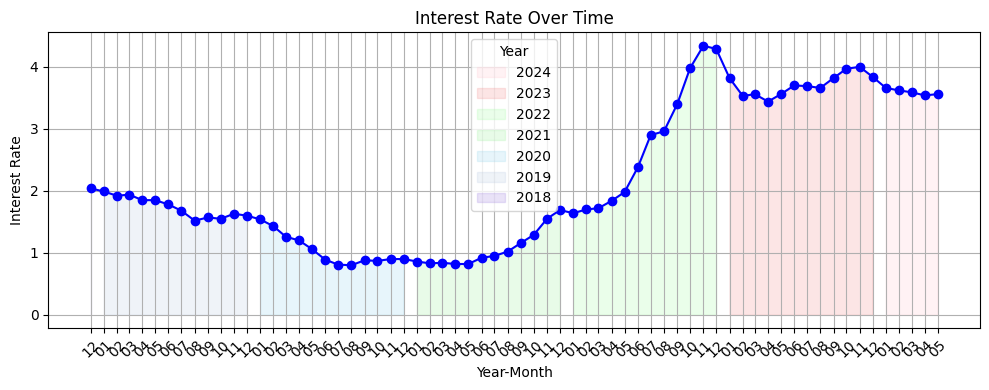

In [52]:
# 'year_month'를 날짜 형식으로 변환 (연월을 'YYYYMM'에서 날짜로)
interestRate['year_month_date'] = pd.to_datetime(interestRate['year_month'].astype(str) + '01', format='%Y%m%d')

# 그래프 크기 설정
plt.figure(figsize=(10, 4))

# 금리 변화 그래프 그리기
plt.plot(interestRate['year_month_date'], interestRate['interest_rate'], marker='o', color='b')

# 연도별 색상 지정 (원하는 색상으로 맞춤)
year_colors = {
    2018: 'mediumpurple',
    2019: 'lightsteelblue',
    2020: 'skyblue',
    2021: 'lightgreen',
    2022: 'palegreen',
    2023: 'lightcoral',
    2024: 'pink'
}

# 연도별 색상을 맞춰서 그래프에 색상 채우기
for year in interestRate['year_month_date'].dt.year.unique():
    year_data = interestRate[interestRate['year_month_date'].dt.year == year]
    plt.fill_between(year_data['year_month_date'], year_data['interest_rate'], color=year_colors.get(year, 'gray'), alpha=0.2, label=str(year))

# x축 레이블을 월별로만 표시
plt.xticks(interestRate['year_month_date'], interestRate['year_month_date'].dt.strftime('%m'), rotation=45)

# 범례 추가 (연도 구분)
plt.legend(title="Year")

# 그래프 제목 및 축 레이블 추가
plt.title('Interest Rate Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Interest Rate')
plt.grid(True)

# 그래프 표시
plt.tight_layout()
plt.show()

#### (2) 시간에 따른 target avg 그려보기

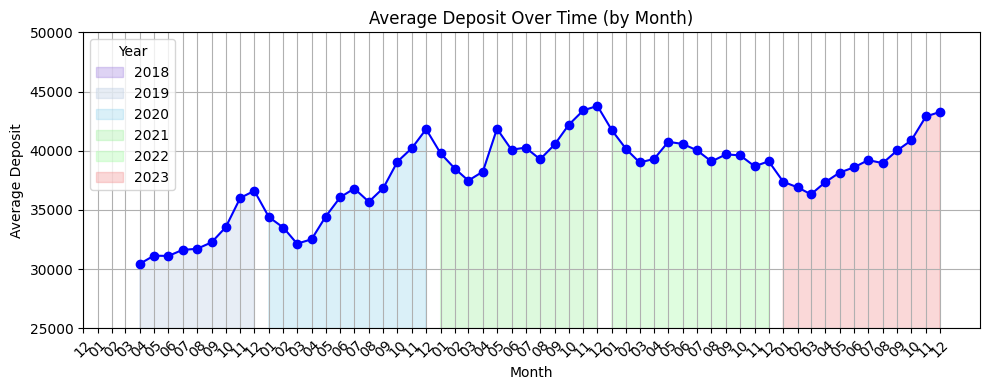

In [53]:
# 'contract_year_month'를 문자열에서 연도-월 형식으로 변환
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')

# 월별로 타겟값 'deposit'의 평균 계산
monthly_deposit = train_data.groupby(train_data['contract_year_month'].dt.to_period('M'))['deposit'].mean()

# 201812부터 마지막 월까지 모든 월을 포함하도록 인덱스를 재구성
start_period = pd.Period('2018-12', freq='M')
end_period = monthly_deposit.index.max()
all_months = pd.period_range(start=start_period, end=end_period, freq='M')

# 재구성된 인덱스로 데이터를 재배열하고, 없는 값은 NaN으로 채우기
monthly_deposit = monthly_deposit.reindex(all_months)

# 그래프 크기 설정
plt.figure(figsize=(10, 4))

# 전체 데이터를 한 번에 그려 이어지게 함
plt.plot(monthly_deposit.index.to_timestamp(), monthly_deposit.values, marker='o', color='b')

# 연도별 색상 지정 (원하는 색상으로 맞춤)
year_colors = {
    2018: 'mediumpurple',
    2019: 'lightsteelblue',
    2020: 'skyblue',
    2021: 'lightgreen',
    2022: 'palegreen',
    2023: 'lightcoral',
    2024: 'pink'
}

# 연도별로 fill_between을 사용하여 영역을 색으로 채움
for year in monthly_deposit.index.year.unique():
    year_data = monthly_deposit[monthly_deposit.index.year == year]
    plt.fill_between(year_data.index.to_timestamp(), year_data.values, color=year_colors[year], alpha=0.3, label=str(year))

# y축 범위 설정
plt.ylim(25000, 50000)

# x축에는 월만 표시
plt.xticks(monthly_deposit.index.to_timestamp(), monthly_deposit.index.strftime('%m'), rotation=45)

# 연도별 색상 구분을 위한 범례 추가
plt.legend(title="Year")

# 그래프 제목 및 축 레이블 추가
plt.title('Average Deposit Over Time (by Month)')
plt.xlabel('Month')
plt.ylabel('Average Deposit')
plt.grid(True)

# 그래프 표시
plt.tight_layout()
plt.show()

#### (3) interest rate + target avg 그래프

##### (3)-1. 그래프

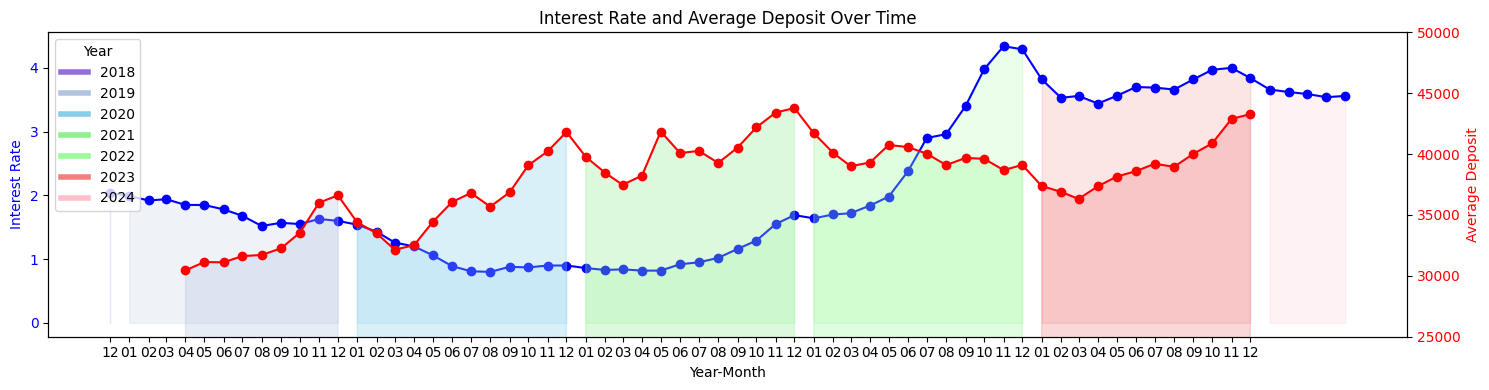

In [54]:
# 'year_month'를 날짜 형식으로 변환 (연월을 'YYYYMM'에서 날짜로)
interestRate['year_month_date'] = pd.to_datetime(interestRate['year_month'].astype(str) + '01', format='%Y%m%d')

# 'contract_year_month'를 문자열에서 연도-월 형식으로 변환
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')

# 월별로 타겟값 'deposit'의 평균 계산
monthly_deposit = train_data.groupby(train_data['contract_year_month'].dt.to_period('M'))['deposit'].mean()

# 201812부터 마지막 월까지 모든 월을 포함하도록 인덱스를 재구성
start_period = pd.Period('2018-12', freq='M')
end_period = monthly_deposit.index.max()
all_months = pd.period_range(start=start_period, end=end_period, freq='M')

# 재구성된 인덱스로 데이터를 재배열하고, 없는 값은 NaN으로 채우기
monthly_deposit = monthly_deposit.reindex(all_months)

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(15, 4))

# 금리 변화 그래프 그리기 (첫 번째 y축)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Interest Rate', color='b')
ax1.plot(interestRate['year_month_date'], interestRate['interest_rate'], marker='o', color='b', label='Interest Rate')

# 연도별 색상 지정 (원하는 색상으로 맞춤)
year_colors = {
    2018: 'mediumpurple',
    2019: 'lightsteelblue',
    2020: 'skyblue',
    2021: 'lightgreen',
    2022: 'palegreen',
    2023: 'lightcoral',
    2024: 'pink'
}

# 금리 변화 그래프에 색상 채우기
for year in interestRate['year_month_date'].dt.year.unique():
    year_data = interestRate[interestRate['year_month_date'].dt.year == year]
    ax1.fill_between(year_data['year_month_date'], year_data['interest_rate'], color=year_colors.get(year, 'gray'), alpha=0.2)

ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축 설정 (전세 실거래가)
ax2 = ax1.twinx()
ax2.set_ylabel('Average Deposit', color='r')
ax2.plot(monthly_deposit.index.to_timestamp(), monthly_deposit.values, marker='o', color='r', label='Average Deposit')

# 연도별로 fill_between을 사용하여 전세 실거래가 영역을 색으로 채움
for year in monthly_deposit.index.year.unique():
    year_data = monthly_deposit[monthly_deposit.index.year == year]
    ax2.fill_between(year_data.index.to_timestamp(), year_data.values, color=year_colors[year], alpha=0.3)

ax2.tick_params(axis='y', labelcolor='r')

# y축 범위 설정
ax2.set_ylim(25000, 50000)

# x축에는 월만 표시
plt.xticks(monthly_deposit.index.to_timestamp(), monthly_deposit.index.strftime('%m'), rotation=45)

# 그래프 제목 추가
plt.title('Interest Rate and Average Deposit Over Time')

# 연도별 색상 범례 추가 (왼쪽 위에 위치)
custom_lines = [plt.Line2D([0], [0], color=year_colors[year], lw=4) for year in year_colors]
plt.legend(custom_lines, year_colors.keys(), title="Year", loc='upper left')

# 그래프 표시
plt.tight_layout()
plt.show()

##### (3)-2. 연도와 월이 같은 경우 평균 전세값과 금리의 상관관계

In [55]:
# 'contract_year_month'를 연도와 월 형식으로 변환
train_data['contract_year_month'] = pd.to_datetime(train_data['contract_year_month'], format='%Y%m')

# 금리 데이터도 같은 형식으로 변환
interestRate['year_month_date'] = pd.to_datetime(interestRate['year_month'].astype(str) + '01', format='%Y%m%d')

# 'year'와 'month'를 각각의 열로 추출하여 년월을 모두 고려
train_data['year'] = train_data['contract_year_month'].dt.year
train_data['month'] = train_data['contract_year_month'].dt.month

interestRate['year'] = interestRate['year_month_date'].dt.year
interestRate['month'] = interestRate['year_month_date'].dt.month

# 월별로 평균 전세값을 구한 후, 연도와 월을 기준으로 병합
monthly_avg = train_data.groupby(['year', 'month'])['deposit'].mean().reset_index()
monthly_avg = monthly_avg.merge(interestRate[['year', 'month', 'interest_rate']], on=['year', 'month'], how='inner')

# 상관관계 계산
correlation = monthly_avg['deposit'].corr(monthly_avg['interest_rate'])

print(f"연도와 월이 같은 경우 전세값과 금리의 상관관계: {correlation}")


연도와 월이 같은 경우 전세값과 금리의 상관관계: 0.20654764072191414


### 3. 상위 10개 아파트 단지 (위치 기준) - 월별 평균 전세 실거래가

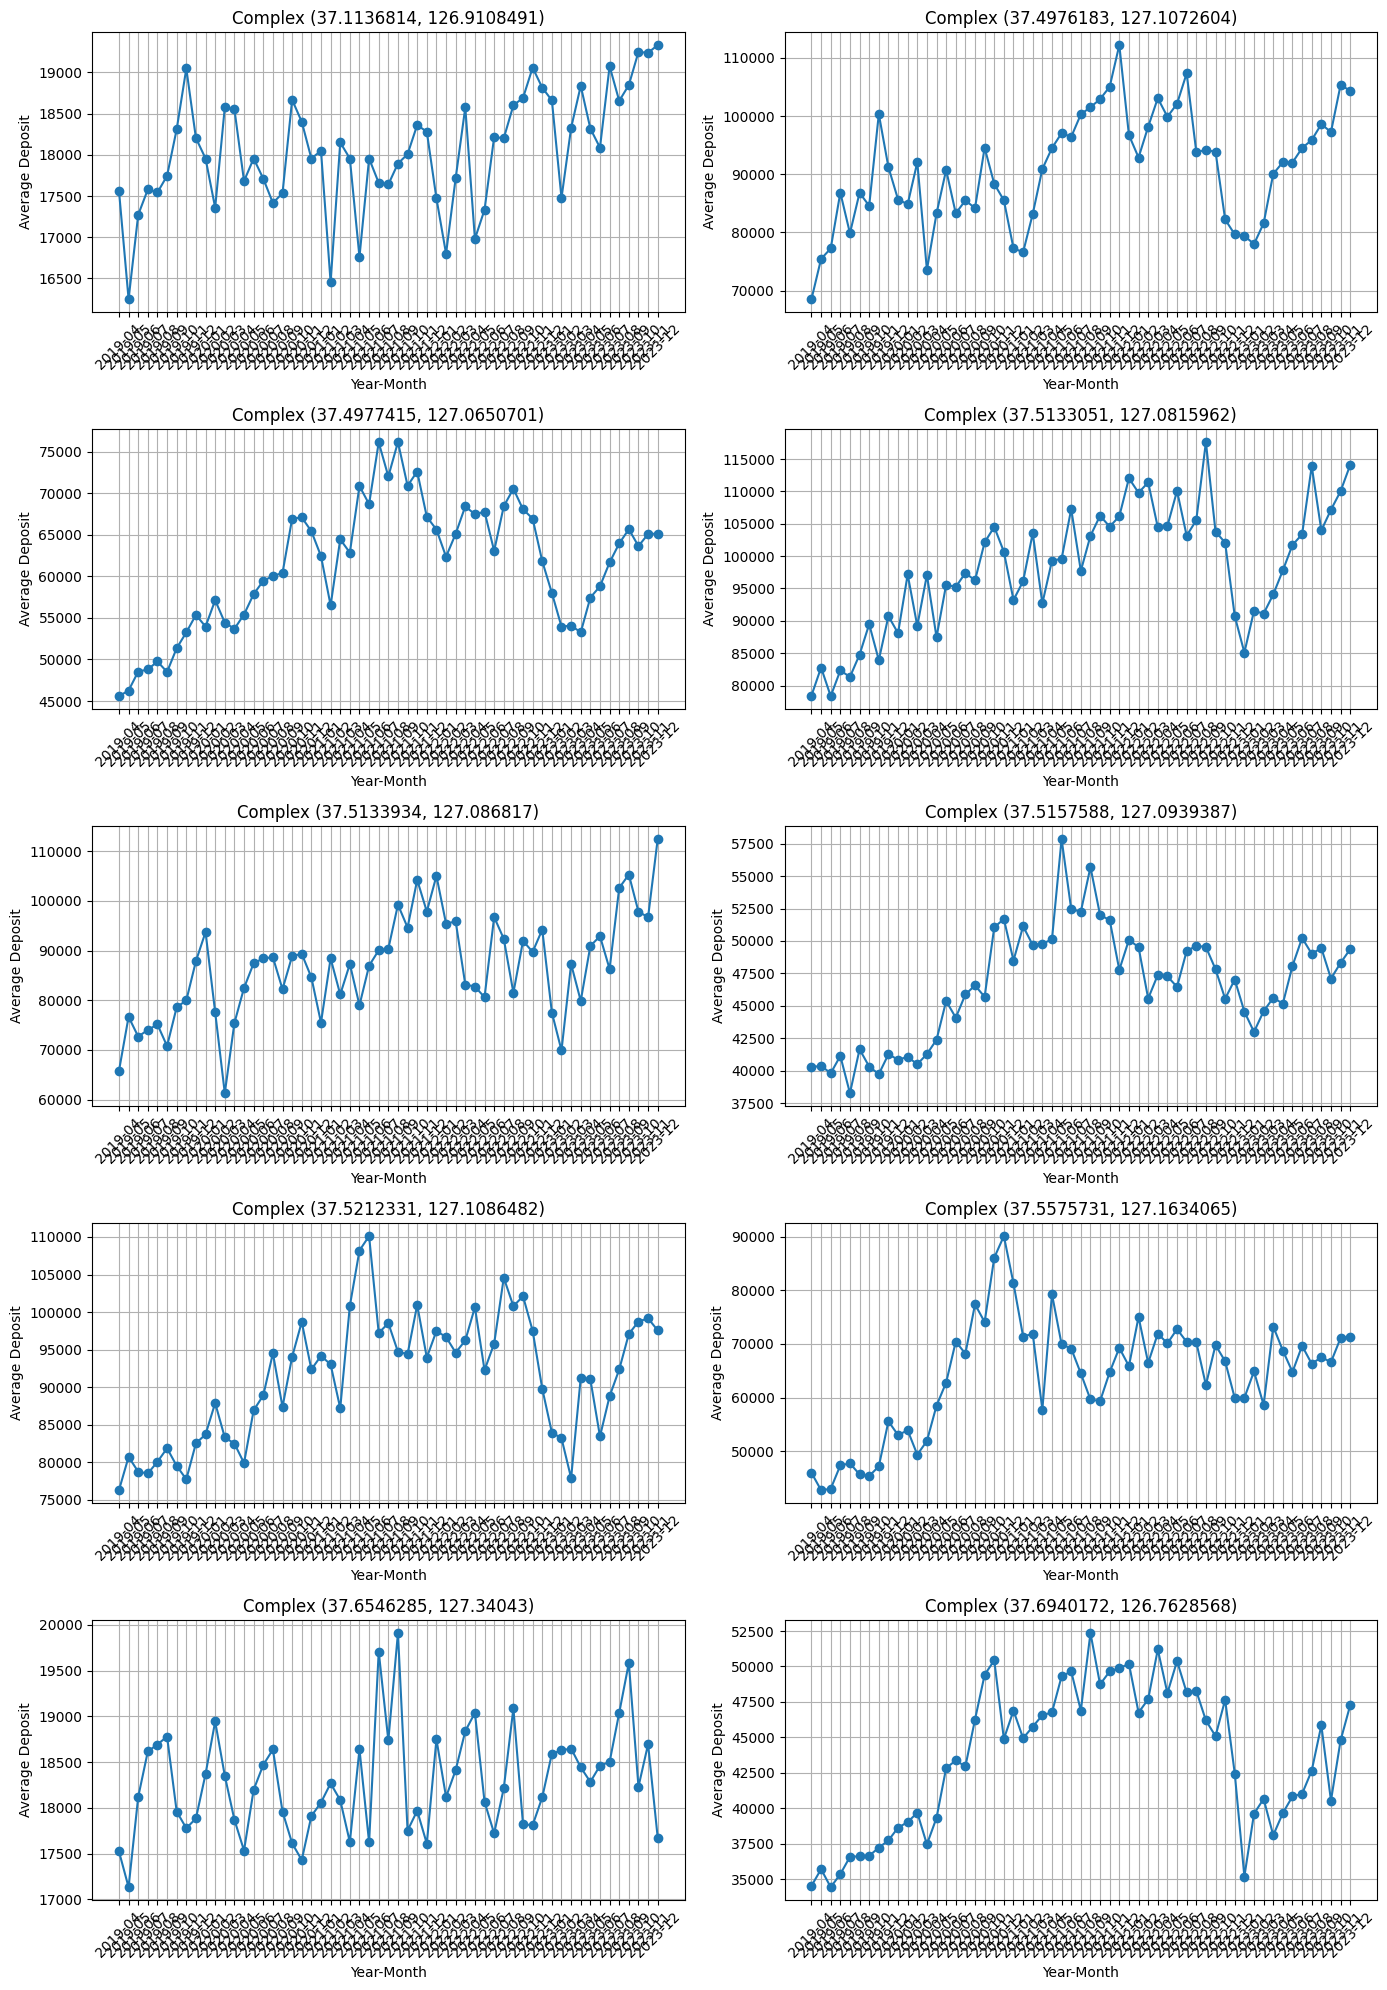

In [56]:
# latitude와 longitude를 기준으로 빈도수 계산 (단지별 등장 횟수)
complex_frequency = train_data.groupby(['latitude', 'longitude']).size().reset_index(name='count')

# 빈도수가 많은 상위 10개의 단지 추출
top_10_complexes = complex_frequency.nlargest(10, 'count')

# 상위 10개의 단지에 해당하는 데이터만 필터링
top_10_data = train_data.merge(top_10_complexes[['latitude', 'longitude']], on=['latitude', 'longitude'])

# 'contract_year_month'를 연월 형식으로 변환
top_10_data['contract_year_month'] = pd.to_datetime(top_10_data['contract_year_month'], format='%Y%m')

# latitude, longitude, 연월을 기준으로 평균 deposit 계산
top_10_avg_deposit = top_10_data.groupby(['latitude', 'longitude', top_10_data['contract_year_month'].dt.to_period('M')]).agg({'deposit': 'mean'}).reset_index()

# 'contract_year_month'를 문자열로 변환
top_10_avg_deposit['contract_year_month'] = top_10_avg_deposit['contract_year_month'].astype(str)

# 5행 2열의 서브플롯 생성
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
axes = axes.flatten()  # 5행 2열의 서브플롯을 1차원 배열로 변환

# 각 단지에 대해 그래프 그리기
for idx, ((lat, lon), group_data) in enumerate(top_10_avg_deposit.groupby(['latitude', 'longitude'])):
    axes[idx].plot(group_data['contract_year_month'], group_data['deposit'], marker='o')
    axes[idx].set_title(f'Complex ({lat}, {lon})')
    axes[idx].set_xlabel('Year-Month')
    axes[idx].set_ylabel('Average Deposit')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True)

# 빈 서브플롯이 있을 경우 숨기기
for ax in axes[len(top_10_avg_deposit.groupby(['latitude', 'longitude'])):]:
    ax.axis('off')

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()

>2023년 1월쯤에 한번 떨어져주는 양상이 보이는거 같기도? (금리 폭등 후..)

### processed_data 가져오기

In [57]:
pd.options.display.float_format = '{:.5f}'.format

In [58]:
file_path = '../data/'

df = pd.read_csv(file_path + 'processed_data.csv')

In [59]:
df = pd.read_csv(file_path + 'processed_data.csv')
train_data = df[df['_type'] == 'train'].drop(columns=['_type', 'year_month_date'])
test_data = df[df['_type'] == 'test'].drop(columns=['_type', 'year_month_date'])
sample_submission = pd.read_csv(file_path + 'sample_submission.csv')

#### 변수별 분포

In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1801228 entries, 0 to 1801227
Data columns (total 19 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   index                           int64  
 1   area_m2                         float64
 2   contract_year_month             int64  
 3   contract_day                    int64  
 4   contract_type                   int64  
 5   floor                           int64  
 6   built_year                      int64  
 7   latitude                        float64
 8   longitude                       float64
 9   age                             int64  
 10  deposit                         float64
 11  nearest_subway_distance_km      float64
 12  interest_rate                   float64
 13  prev_month_interest_rate        float64
 14  nearest_elementary_distance_km  float64
 15  nearest_middle_distance_km      float64
 16  nearest_high_distance_km        float64
 17  nearest_park_distance_km        

In [61]:
train_data.describe()

,index,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,nearest_subway_distance_km,interest_rate,prev_month_interest_rate,nearest_elementary_distance_km,nearest_middle_distance_km,nearest_high_distance_km,nearest_park_distance_km,nearest_park_area
count,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000,1801228.00000
mean,900613.50000,75.18833,202133.12602,15.89943,1.20380,10.05197,2004.19877,37.47721,126.96623,17.06597,38162.22942,1.42535,2.15760,2.12205,0.33447,0.53054,0.68884,0.26273,15767.18707
std,519969.87967,25.52632,135.28146,8.62600,0.88528,6.97336,11.15132,0.16251,0.17012,11.12796,26103.77420,2.09935,1.19130,1.17363,0.19499,0.36966,0.50422,0.28889,63099.98194
min,0.00000,10.32150,201904.00000,1.00000,0.00000,-4.00000,1961.00000,36.91791,126.47871,-3.00000,300.00000,0.02793,0.80000,0.80000,0.02052,0.01578,0.02096,0.00000,0.00000
25%,450306.75000,59.75000,202008.00000,9.00000,0.00000,5.00000,1995.00000,37.37976,126.84216,7.00000,21000.00000,0.43673,1.06000,1.06000,0.20578,0.29118,0.36039,0.13032,1500.10000
50%,900613.50000,77.15000,202111.00000,16.00000,2.00000,9.00000,2004.00000,37.50227,126.99759,17.00000,32000.00000,0.72629,1.69000,1.69000,0.29735,0.45738,0.57809,0.19966,2409.00000
75%,1350920.25000,84.96000,202212.00000,23.00000,2.00000,14.00000,2015.00000,37.58205,127.08881,26.00000,47800.00000,1.43739,3.56000,3.53000,0.40917,0.66601,0.87784,0.30689,8929.00000
max,1801227.00000,317.36000,202312.00000,31.00000,2.00000,68.00000,2024.00000,38.18194,127.66090,62.00000,1100000.00000,26.28670,4.34000,4.34000,3.39939,5.83878,8.56636,7.82052,1764901.70000


### 상관관계 히트맵
| 변수                                      | 상관관계      |
|-------------------------------------------|--------------|
| **`deposit`과 `area_m2`**                   | **매우 높은 양의 상관관계** |
| `contract_year_month`과 `contract_type`  | 높은 음의 상관관계(왜지?>> 걍 우연일듯?)  |
| `contract_year_month`과 `interest_rate`  | 높은 양의 상관관계()  |
| `contract_year_month`과 `prev_month_interest_rate` | 높은 양의 상관관계  |
| `contract_type`과 `interest_rate`         | 높은 음의 상관관계  |
| `contract_type`과 `prev_month_interest_rate`  | 높은 음의 상관관계  |
| `floor`과 `built_year`                    | 양의 상관관계    |
| `floor`과 `age`                           | 음의 상관관계    |
| **`built_year`과 `age`**                     | **매우 높은 음의 상관관계** |
| `built_year`과 `nearest_subway_distance_km` | 높은 양의 상관관계  |
| `built_year`과 `elementary`               | 높은 양의 상관관계  |
| `built_year`과 `middle`                   | 높은 양의 상관관계  |
| `built_year`과 `high`                     | 높은 양의 상관관계  |
| **`interest_rate`과 `prev_month_interest_rate`** | **매우 높은 양의 상관관계** |


1. target인 deposit과 area_m2가 가장 높은 상관관계를 갖는 것은 어찌보면 당연함
2. `contract_year_month`과 `interest_rate`의 관계를 보고 싶다면? contract_year_month 값이 커질수록(최근 날짜로 갈수록) interest_rate가 높아진다. 즉, 시간이 지날수록 금리가 올라간다는 뜻. . contract_year_month가 많고 적음에 따른 interest_rate를 봐야하지 않을까?


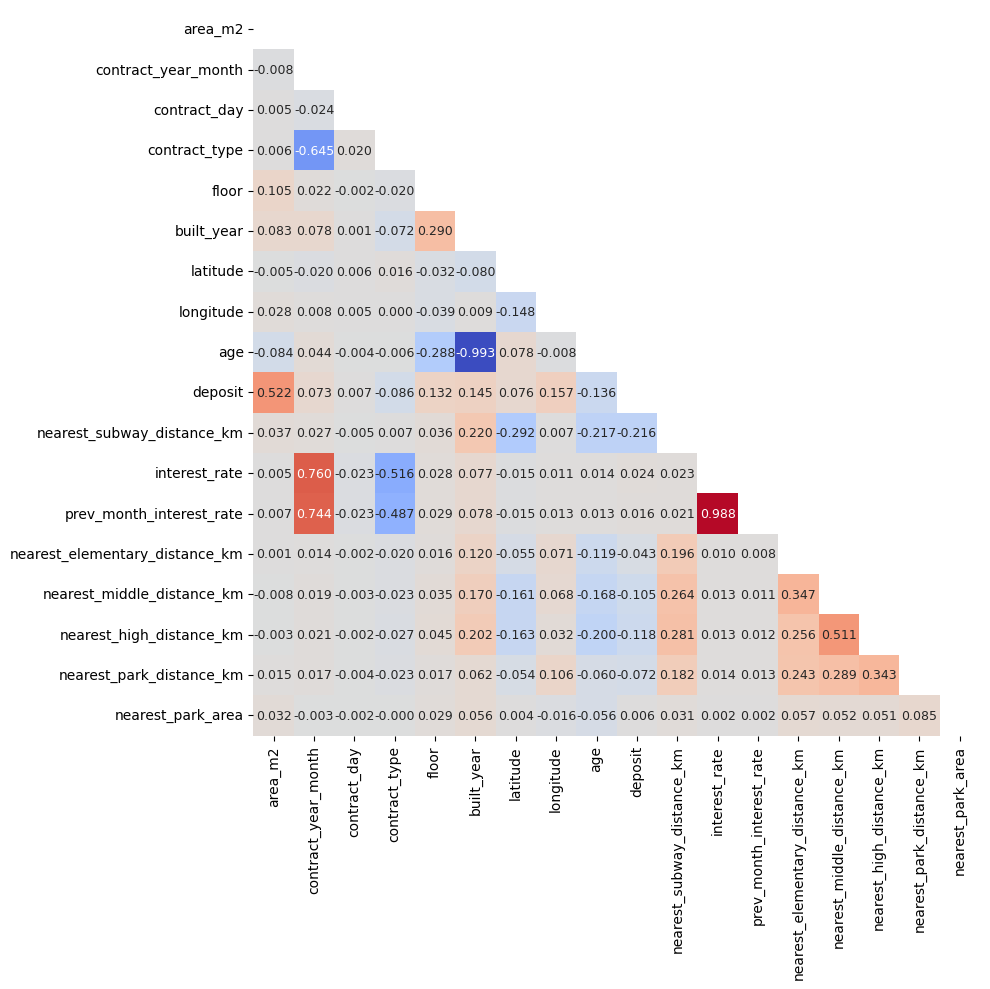

In [62]:
train_corr = train_data.drop(columns='index').corr()
mask = np.triu(np.ones_like(train_corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(train_corr, mask=mask, annot=True, fmt='.3f', cmap='coolwarm',
            square=True, cbar=False, vmin=-1, vmax=1, annot_kws={"size": 9})

plt.tight_layout()
plt.show()